In [62]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, ZeroPadding2D, Input, MaxPool2D, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import torch
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [63]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
torch.cuda.is_available()

Num GPUs Available:  8


True

In [64]:
TRAINING_DIR = '/usr/cs/grad/masters/2026/kbhagat/MLProject/train'
VALIDATION_DIR = '/usr/cs/grad/masters/2026/kbhagat/MLProject/valid'
TESTING_DIR = '/usr/cs/grad/masters/2026/kbhagat/MLProject/test'
BATCH_SIZE = 16
INPUT_SHAPE = (224, 224)
SEED = 777
EPOCHS = 2
GROW_RATE = 16
BASE_FILTERS = 12
NUM_CLASSES = 525
IMAGES_SHAPE = (224, 224, 3)

In [65]:
tf.random.set_seed(SEED)

Found 13670 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 13670 images belonging to 525 classes.
Batch index: 465


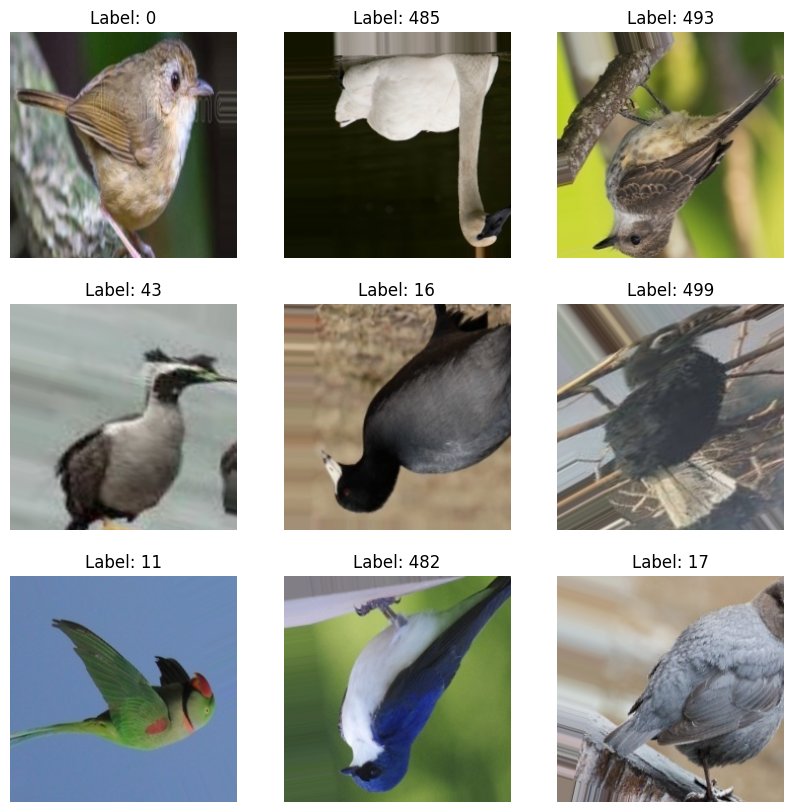

In [66]:
training_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    rotation_range=40
)
training_set = training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)
validation_gen = ImageDataGenerator(rescale=1./255)
validation_set = validation_gen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)

testing_gen = ImageDataGenerator(rescale=1./255)
testing_set = testing_gen.flow_from_directory(
    TESTING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE, 
    class_mode='categorical'
)
# Generating images
generated_images = next(training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=9,
    target_size=INPUT_SHAPE,
    class_mode=None,
    shuffle=False
))

def decode_one_hot(labels):
    return [label.argmax() for label in labels]

# Choose a random batch index from the dataset
batch_index = random.randint(0, len(training_set) - 1)
print("Batch index:", batch_index)

# Retrieve the batch of images and labels
random_images, random_labels = training_set[batch_index]

# Decode the one-hot encoded labels
random_labels = decode_one_hot(random_labels)

# Limit the number of images to display to 9
num_images_to_display = min(len(random_images), 9)

# Display the random images with their corresponding class labels
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Label: {random_labels[i]}")
    plt.axis("off")
plt.show()

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121

def build_densenet_model(num_classes):
    # Load the DenseNet121 model, pre-trained on ImageNet data, excluding the top (classification) layer.
    base_model = DenseNet121(
        include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freeze the layers of the base model to not train them again
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of DenseNet for our specific task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
    # Add a fully-connected layer with softmax activation
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


# Example usage
num_classes = 525 # Change this to the number of classes in your dataset
model = build_densenet_model(num_classes)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.load_weights('my_dense_net.weights.h5')
#model.summary()

In [70]:
history = model.fit(
    training_set,
    #steps_per_epoch=len(training_set),
    epochs=50,  
    validation_data=validation_set,
    #validation_steps=int(0.25*len(validation_set))
)

Epoch 1/50
278/855 ━━━━━━━━━━━━━━━━━━━━ 2:26 254ms/step - accuracy: 0.1102 - loss: 4.5884

I0000 00:00:1713935402.533321 1634278 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11212', 516 bytes spill stores, 516 bytes spill loads

I0000 00:00:1713935402.576200 1634298 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11020', 520 bytes spill stores, 376 bytes spill loads

I0000 00:00:1713935402.586110 1634301 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11212', 512 bytes spill stores, 512 bytes spill loads



855/855 ━━━━━━━━━━━━━━━━━━━━ 365s 408ms/step - accuracy: 0.2950 - loss: 3.4182 - val_accuracy: 0.1577 - val_loss: 11.5937
Epoch 2/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 245s 285ms/step - accuracy: 0.7293 - loss: 1.1205 - val_accuracy: 0.1745 - val_loss: 12.5595
Epoch 3/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 224s 260ms/step - accuracy: 0.7858 - loss: 0.8245 - val_accuracy: 0.1749 - val_loss: 13.1370
Epoch 4/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 202s 234ms/step - accuracy: 0.8175 - loss: 0.6790 - val_accuracy: 0.1752 - val_loss: 13.7885
Epoch 5/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 201s 233ms/step - accuracy: 0.8296 - loss: 0.6181 - val_accuracy: 0.1825 - val_loss: 14.0868
Epoch 6/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 211s 245ms/step - accuracy: 0.8403 - loss: 0.5718 - val_accuracy: 0.1810 - val_loss: 14.6896
Epoch 7/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 263s 304ms/step - accuracy: 0.8460 - loss: 0.5365 - val_accuracy: 0.1806 - val_loss: 15.1425
Epoch 8/50
855/855 ━━━━━━━━━━━━━━━━━━━━ 213s 247ms/step - accuracy: 0.8616 - los

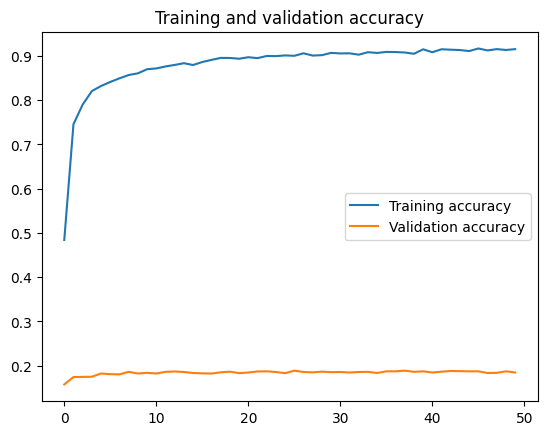

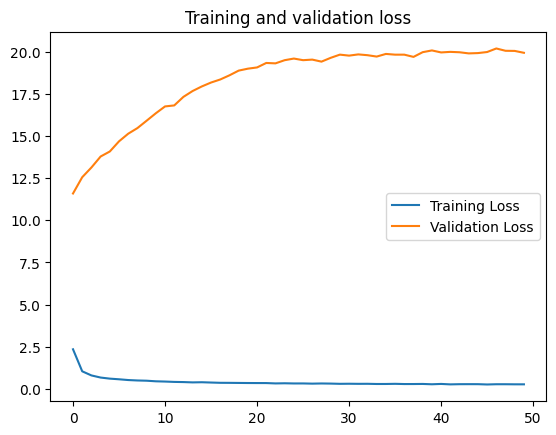

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [72]:
model.save_weights('my_dense_net.weights.h5')

/tmp/ipykernel_2647290/3091727309.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


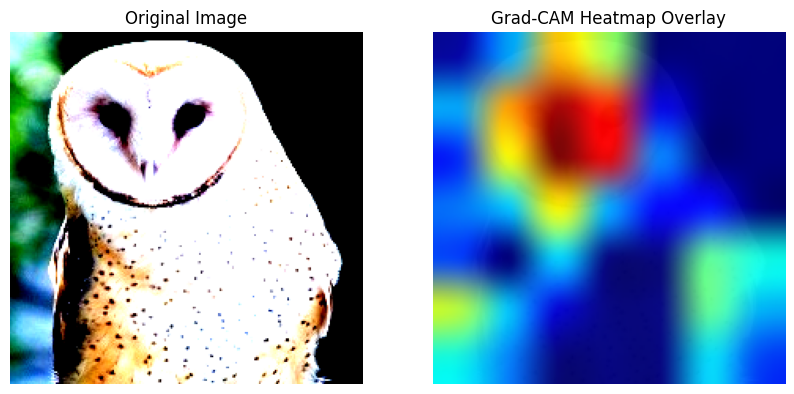

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

# Load an example image from your dataset
img_path = '/usr/cs/grad/masters/2026/kbhagat/MLProject/valid/BARN OWL/2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Define function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Define function to display Grad-CAM heatmap overlayed on original image
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM Heatmap Overlay')

    plt.show()

# Build DenseNet model
def build_densenet_model(num_classes):
    base_model = DenseNet121(
        include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Example usage
num_classes = 525  # Change this to the number of classes in your dataset
model = build_densenet_model(num_classes)

# Define the name of the last convolutional layer in your model
last_conv_layer_name = "conv5_block16_2_conv"

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

# Display the Grad-CAM heatmap overlayed on the original image with adjusted alpha
display_gradcam(x[0], heatmap, alpha=0.4)  # Adjust alpha here


In [74]:
from sklearn.metrics import classification_report

# Initialize empty lists to hold predictions and true labels
all_preds = []
all_true_labels = []

# Estimate the length of the validation set
validation_samples = len(validation_set.filenames)
batch_size = validation_set.batch_size
estimated_length = validation_samples // batch_size
print("Estimated Validation Set Length:", estimated_length)

# Manually iterate over the estimated length of the validation set
for i in range(estimated_length):
    X_batch, y_batch = next(validation_set)
    preds = model.predict_on_batch(X_batch)
    # Print dimensions of predictions and batch number
    print("Batch", i+1, "Prediction shape:", preds.shape)
    # Store batch predictions and labels
    all_preds.extend(np.argmax(preds, axis=1))
    all_true_labels.extend(np.argmax(y_batch, axis=1))

# Convert lists to arrays for evaluation
all_preds = np.array(all_preds)
print("All Predictions:", all_preds)
all_true_labels = np.array(all_true_labels)
print("All True Labels:", all_true_labels)

# Print the evaluation report
print(classification_report(all_true_labels, all_preds))


Estimated Validation Set Length: 164
Batch 1 Prediction shape: (16, 525)
Batch 2 Prediction shape: (16, 525)
Batch 3 Prediction shape: (16, 525)
Batch 4 Prediction shape: (16, 525)
Batch 5 Prediction shape: (16, 525)
Batch 6 Prediction shape: (16, 525)
Batch 7 Prediction shape: (16, 525)
Batch 8 Prediction shape: (16, 525)
Batch 9 Prediction shape: (16, 525)
Batch 10 Prediction shape: (16, 525)
Batch 11 Prediction shape: (16, 525)
Batch 12 Prediction shape: (16, 525)
Batch 13 Prediction shape: (16, 525)
Batch 14 Prediction shape: (16, 525)
Batch 15 Prediction shape: (16, 525)
Batch 16 Prediction shape: (16, 525)
Batch 17 Prediction shape: (16, 525)
Batch 18 Prediction shape: (16, 525)
Batch 19 Prediction shape: (16, 525)
Batch 20 Prediction shape: (16, 525)
Batch 21 Prediction shape: (16, 525)
Batch 22 Prediction shape: (16, 525)
Batch 23 Prediction shape: (16, 525)
Batch 24 Prediction shape: (16, 525)
Batch 25 Prediction shape: (16, 525)
Batch 26 Prediction shape: (16, 525)
Batch 27 P

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
